In [268]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi
import matplotlib.ticker as ticker

# setting plt to inline
%matplotlib inline

# updating cpi if flagged out of date
# cpi.update()

In [72]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query functions
def fetcha(q):
    return cur.execute(q).fetchall()
def fetcho(q):
    return cur.execute(q).fetchone()

In [73]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [74]:
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [75]:
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [201]:
# creating initial dataframe by joining the four tables and printing first row
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       
       """
df = pd.DataFrame(fetcha(q))
df.columns = [i[0] for i in cur.description]   

In [202]:
# dropping extraneous columns
df = df.drop(['idx', 'rotten_tomatoes_link', 'movie_info', 'critics_consensus', 'directors',\
             'authors', 'actors', 'original_release_date', 'streaming_release_date',\
             'runtime', 'production_company', 'tomatometer_status', 'tomatometer_rating',\
             'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count',\
             'id', 'movie'], axis=1)
df.head(1)

,movie_title,content_rating,genres,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,release_date,production_budget,domestic_gross,worldwide_gross
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",43,73,76,"Feb 12, 2010","$95,000,000","$88,768,303","$223,050,874"


In [203]:
df.columns

Index(['movie_title', 'content_rating', 'genres',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'release_date', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [204]:
# change date string to datetime object 
df.release_date = pd.to_datetime(df.release_date)
df['year'] = df['release_date'].apply(lambda x: x.year)
df['month'] = df['release_date'].apply(lambda x: x.month)

In [205]:
#cleaning numerical strings and converting to floats
df['worldwide_gross'] = df['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['domestic_gross'] = df['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['production_budget'] = df['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [206]:
df['international_gross'] = df['worldwide_gross'].sub(df['domestic_gross'])

In [207]:
df['domestic_net'] = df['domestic_gross'].sub(df['production_budget'])
df['worldwide_net'] = df['worldwide_gross'].sub(df['production_budget'])
df['international_net'] = df['international_gross'].sub(df['production_budget'])

In [208]:
df['domestic_roi'] = df['domestic_net'].divide(df['production_budget'])
df['worldwide_roi'] = df['worldwide_net'].divide(df['production_budget'])
df['international_roi'] = df['international_net'].divide(df['production_budget'])

In [209]:
#adding adjust net profit columns
df['adj_dom_gross'] = df.apply(lambda x: cpi.inflate(x.domestic_gross, x.year), axis=1)
df['adj_ww_gross'] = df.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
df['adj_i_gross'] = df.apply(lambda x: cpi.inflate(x.international_gross, x.year), axis=1)
df['adj_prod_budg'] = df.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   movie_title                       4776 non-null   object        
 1   content_rating                    4776 non-null   object        
 2   genres                            4776 non-null   object        
 3   tomatometer_top_critics_count     4776 non-null   int64         
 4   tomatometer_fresh_critics_count   4776 non-null   int64         
 5   tomatometer_rotten_critics_count  4776 non-null   int64         
 6   release_date                      4776 non-null   datetime64[ns]
 7   production_budget                 4776 non-null   float64       
 8   domestic_gross                    4776 non-null   float64       
 9   worldwide_gross                   4776 non-null   float64       
 10  year                              4776 non-null 

In [210]:
#adding net profit columns
df['adj_dom_net'] = df['adj_dom_gross'].sub(df['adj_prod_budg'])
df['adj_ww_net'] = df['adj_ww_gross'].sub(df['adj_prod_budg'])
df['adj_i_net'] = df['adj_i_gross'].sub(df['adj_prod_budg'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   movie_title                       4776 non-null   object        
 1   content_rating                    4776 non-null   object        
 2   genres                            4776 non-null   object        
 3   tomatometer_top_critics_count     4776 non-null   int64         
 4   tomatometer_fresh_critics_count   4776 non-null   int64         
 5   tomatometer_rotten_critics_count  4776 non-null   int64         
 6   release_date                      4776 non-null   datetime64[ns]
 7   production_budget                 4776 non-null   float64       
 8   domestic_gross                    4776 non-null   float64       
 9   worldwide_gross                   4776 non-null   float64       
 10  year                              4776 non-null 

In [211]:
#adding return on investment columns and checking results
df['adj_dom_roi'] = df['adj_dom_net'].divide(df['adj_prod_budg'])
df['adj_ww_roi'] = df['adj_ww_net'].divide(df['adj_prod_budg'])
df['adj_i_roi'] = df['adj_i_net'].divide(df['adj_prod_budg'])
df.head(1)

,movie_title,content_rating,genres,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,release_date,production_budget,domestic_gross,worldwide_gross,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",43,73,76,2010-02-12,95000000.0,88768303.0,223050874.0,...,1.040753e+08,2.615132e+08,1.574379e+08,1.113815e+08,-7.306274e+06,1.501316e+08,4.605635e+07,-0.065597,1.347904,0.413501


In [212]:
df.columns

Index(['movie_title', 'content_rating', 'genres',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'release_date', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

In [213]:
df = df.rename(columns = {'movie_title':'title', 'release_date':'date',\
                          'content_rating': 'rating', 'genres': 'genres',\
                          'tomatometer_top_critics_count': 'top', 'tomatometer_fresh_critics_count': 'fresh',\
                          'tomatometer_rotten_critics_count': 'rotten'})
df.columns

Index(['title', 'rating', 'genres', 'top', 'fresh', 'rotten', 'date',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'year',
       'month', 'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

## Top 100 Films by Worldwide Gross

In [214]:
title_gross = df[['title', 'production_budget', 'worldwide_gross', 'worldwide_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_titles = title_gross.groupby('title').first().reset_index()
top100_gross_films = unique_titles.sort_values(by='worldwide_gross', ascending=False).head(100)
top100_gross_films

,title,production_budget,worldwide_gross,worldwide_net,worldwide_roi,genres,year,month
321,Avatar,425000000.0,2.776345e+09,2.351345e+09,5.532577,"Action & Adventure, Comedy, Mystery & Suspense...",2009,12
3920,Titanic,200000000.0,2.208208e+09,2.008208e+09,10.041042,"Action & Adventure, Classics, Drama, Romance",1997,12
323,Avengers: Infinity War,300000000.0,2.048134e+09,1.748134e+09,5.827114,"Action & Adventure, Science Fiction & Fantasy",2018,4
1691,Jurassic World,215000000.0,1.648855e+09,1.433855e+09,6.669092,"Action & Adventure, Mystery & Suspense, Scienc...",2015,6
1223,Furious 7,190000000.0,1.518723e+09,1.328723e+09,6.993278,"Action & Adventure, Mystery & Suspense",2015,4
...,...,...,...,...,...,...,...,...
1600,Interstellar,165000000.0,6.663794e+08,5.013794e+08,3.038663,"Action & Adventure, Science Fiction & Fantasy",2014,11
1761,Kung Fu Panda 2,150000000.0,6.648375e+08,5.148375e+08,3.432250,"Action & Adventure, Animation, Comedy, Kids & ...",2011,5
1700,Justice League,300000000.0,6.559452e+08,3.559452e+08,1.186484,"Action & Adventure, Drama, Science Fiction & F...",2017,11
3531,The Martian,108000000.0,6.552714e+08,5.472714e+08,5.067328,Science Fiction & Fantasy,2015,10


In [219]:
title_adj_gross = df[['title', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_adj_titles = title_adj_gross.groupby('title').first().reset_index()
top100_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top100_adj_gross_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
352,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,311.354312,"Animation, Classics, Kids & Family, Science Fi...",1942,8
3920,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,10.041042,"Action & Adventure, Classics, Drama, Romance",1997,12
321,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,5.532577,"Action & Adventure, Comedy, Mystery & Suspense...",2009,12
2795,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,123.277880,"Animation, Classics, Kids & Family, Science Fi...",1937,12
3241,The Exorcist,6.909649e+07,2.465676e+09,2.396580e+09,34.684540,"Classics, Horror",1973,12
...,...,...,...,...,...,...,...,...
4037,Up,2.085420e+08,8.716619e+08,6.631199e+08,3.179791,"Action & Adventure, Animation, Comedy, Kids & ...",2009,5
296,Armageddon,2.195827e+08,8.698612e+08,6.502785e+08,2.961429,"Action & Adventure, Mystery & Suspense, Scienc...",1998,7
4064,Venom,1.181019e+08,8.690962e+08,7.509943e+08,6.358867,"Cult Movies, Horror, Mystery & Suspense",2018,10
4205,Wonder Woman,1.564481e+08,8.564315e+08,6.999835e+08,4.474223,"Action & Adventure, Animation, Drama, Kids & F...",2017,6


In [220]:
top100_gross_films.describe()

,production_budget,worldwide_gross,worldwide_net,worldwide_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.685750e+08,9.576570e+08,7.890820e+08,5.846388,2011.340000,7.250000
std,7.397127e+07,3.273300e+08,3.019174e+08,3.688244,6.067333,2.903759
min,3.500000e+07,6.522201e+08,3.559452e+08,1.186484,1993.000000,2.000000
25%,1.100000e+08,7.578371e+08,6.014434e+08,3.236404,2009.000000,5.000000
50%,1.725000e+08,8.794230e+08,7.003720e+08,4.513429,2013.000000,6.000000
75%,2.000000e+08,1.040525e+09,8.783895e+08,7.029846,2016.000000,11.000000
max,4.250000e+08,2.776345e+09,2.351345e+09,18.927371,2019.000000,12.000000


In [222]:
top100_adj_gross_films.describe()

,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.687481e+08,1.277631e+09,1.108883e+09,16.019202,2001.810000,7.580000
std,9.581017e+07,5.732113e+08,5.769721e+08,39.681137,17.395399,3.012365
min,4.493093e+06,8.547247e+08,6.252047e+08,1.546673,1937.000000,2.000000
25%,8.805160e+07,9.490569e+08,8.062123e+08,4.006988,1994.000000,5.000000
50%,1.792323e+08,1.115988e+09,9.634766e+08,5.697061,2008.500000,7.000000
75%,2.201631e+08,1.304167e+09,1.156453e+09,11.970308,2015.000000,11.000000
max,5.064591e+08,4.203440e+09,4.189983e+09,311.354312,2019.000000,12.000000


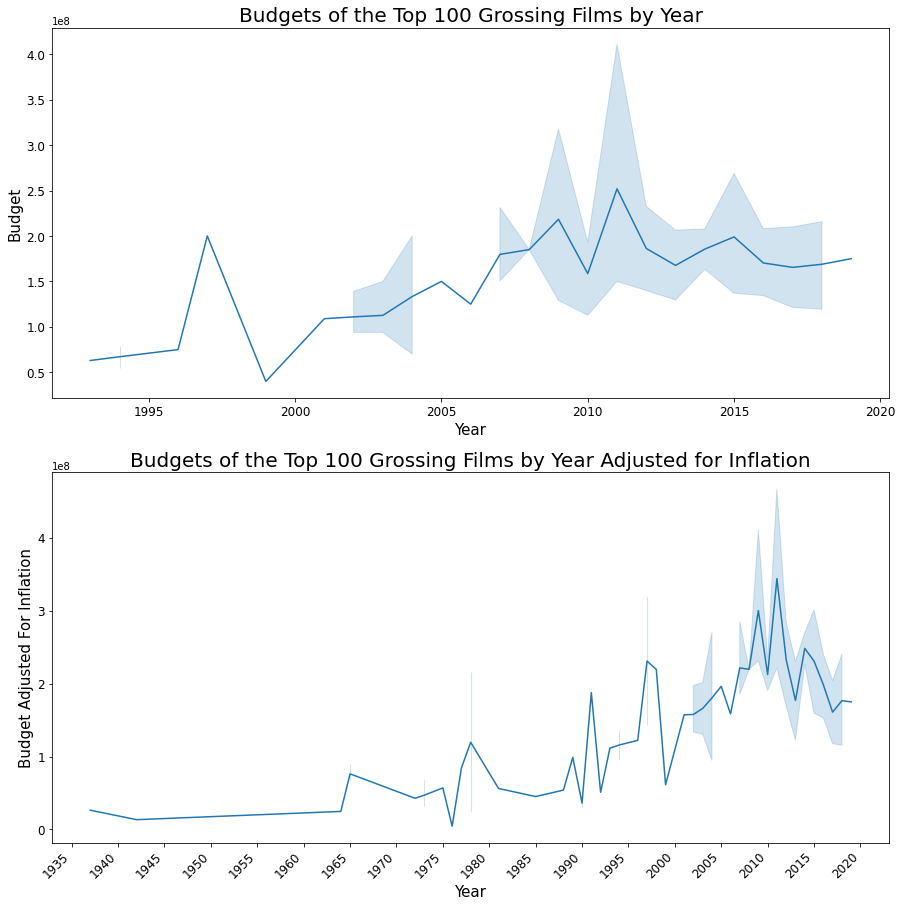

In [269]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.lineplot(x='year', y='production_budget', data=top100_gross_films, ax=ax1)
sns.lineplot(x='year', y='adj_prod_budg', data=top100_adj_gross_films, ax=ax2)
# adjusting xticks
plt.xticks(rotation=45, ha='right')
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())

# label for x-axis 
ax1.set_xlabel( "Year", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Budget", size = 15 ) 
ax2.set_ylabel( "Budget Adjusted For Inflation", size = 15 ) 
# title for plot 
ax1.set_title( "Budgets of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Budgets of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 ) 
plt.show()

In [228]:
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_count_by_year.head(1)

,year,count
0,2017,11


In [226]:
t100_adj_count_by_year = pd.DataFrame(top100_adj_gross_films.year.value_counts()).reset_index()
t100_adj_count_by_year = t100_adj_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_adj_count_by_year.head(1)

,year,count
0,2017,7


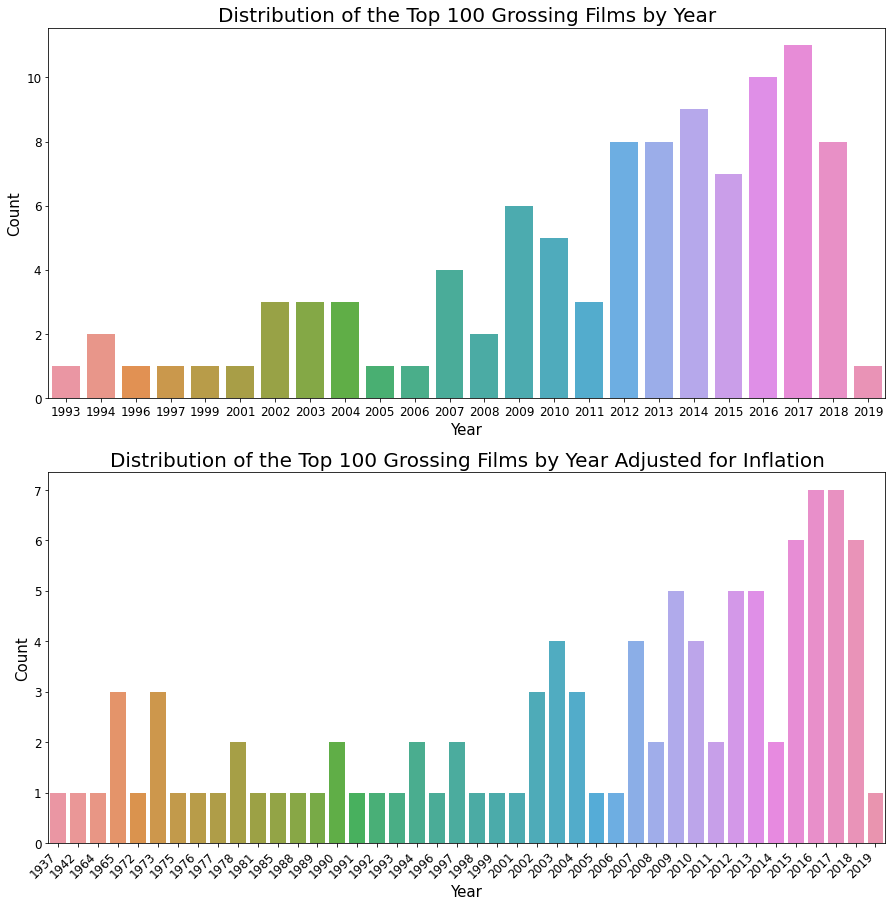

In [260]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.barplot(x='year', y= 'count', data=t100_count_by_year, ax = ax1)
sns.barplot(x='year', y= 'count', data=t100_adj_count_by_year, ax = ax2)
# adjusting xticks
plt.xticks(rotation=45, ha='right')
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
# label for x-axis 
ax1.set_xlabel( "Year", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Count", size = 15 ) 
ax2.set_ylabel( "Count", size = 15 ) 
# title for plot 
ax1.set_title( "Distribution of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Distribution of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 ) 
# render
plt.show()

In [230]:
t100_gross_by_roi = top100_gross_films.sort_values(by='worldwide_roi', ascending=False)
t100_gross_by_roi.head()

,title,production_budget,worldwide_gross,worldwide_net,worldwide_roi,genres,year,month
1619,It,35000000.0,6.974580e+08,6.624580e+08,18.927371,"Classics, Comedy, Drama, Romance",2017,9
3749,The Sixth Sense,40000000.0,6.728063e+08,6.328063e+08,15.820157,Mystery & Suspense,1999,8
1689,Jurassic Park,63000000.0,1.038813e+09,9.758126e+08,15.489089,"Action & Adventure, Mystery & Suspense, Scienc...",1993,6
505,Bohemian Rhapsody,55000000.0,8.949853e+08,8.399853e+08,15.272461,Drama,2018,11
2040,Minions,74000000.0,1.160336e+09,1.086336e+09,14.680219,"Animation, Comedy, Kids & Family",2015,7


In [232]:
t100_adj_gross_by_roi = top100_adj_gross_films.sort_values(by='adj_ww_roi', ascending=False)
t100_adj_gross_by_roi.head()

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
352,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,311.354312,"Animation, Classics, Kids & Family, Science Fi...",1942,8
2557,Rocky,4.493093e+06,1.010946e+09,1.006453e+09,224.000000,"Drama, Sports & Fitness",1976,11
2795,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,123.277880,"Animation, Classics, Kids & Family, Science Fi...",1937,12
1315,Grease,2.352672e+07,1.519474e+09,1.495947e+09,63.585030,"Comedy, Musical & Performing Arts, Romance",1978,6
1292,Goldfinger,2.474100e+07,1.030050e+09,1.005309e+09,40.633333,"Action & Adventure, Classics, Mystery & Suspense",1964,12


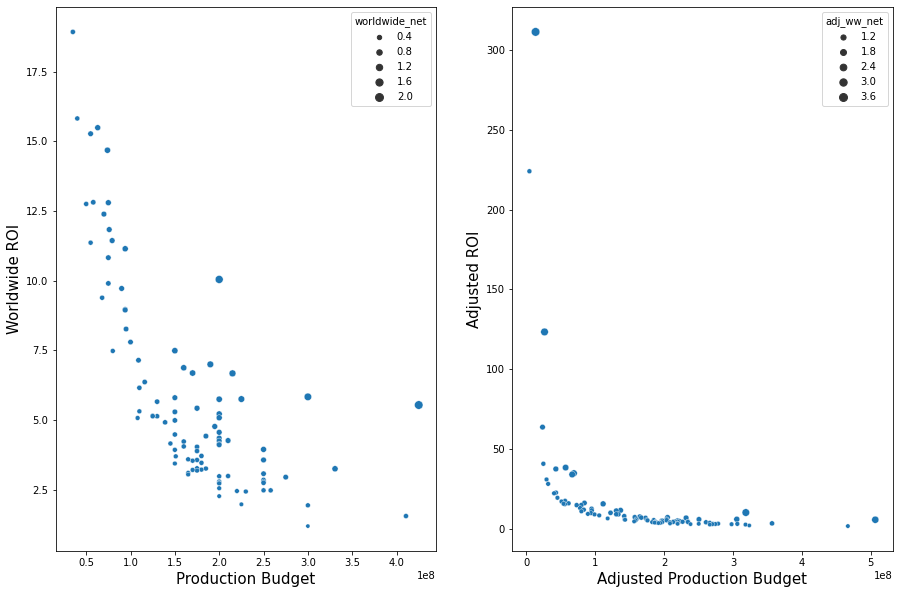

In [271]:
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(15,10))

sns.scatterplot(x='production_budget', y='worldwide_roi', data=top100_gross_films, size='worldwide_net', ax=ax1)

sns.scatterplot(x='adj_prod_budg', y='adj_ww_roi', data=top100_adj_gross_films, size='adj_ww_net', ax=ax2)

#label for x-axis 
ax1.set_xlabel( "Production Budget" , fontsize=15 )
ax2.set_xlabel("Adjusted Production Budget", fontsize=15)
#label for y-axis 
ax1.set_ylabel( "Worldwide ROI", fontsize=15)
ax2.set_ylabel("Adjusted ROI", fontsize=15)
# setting title
ax.axes.set_title("Actors With Top Average Gross per Movie", fontsize=30)


plt.show()

In [94]:
title_net = df[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'year']]
unique_titles = title_net.groupby('title').first().reset_index()
top100_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top100_net_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,year
352,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,1942
2795,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,1937
3920,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,1997
321,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,2009
3241,The Exorcist,6.909649e+07,2.465676e+09,2.396580e+09,1973
...,...,...,...,...,...
3958,Transformers: Revenge of the Fallen,2.502504e+08,9.968542e+08,7.466038e+08,2009
769,Crocodile Dundee,2.052720e+07,7.655796e+08,7.450524e+08,1986
420,Beverly Hills Cop,3.690910e+07,7.782898e+08,7.413807e+08,1984
1648,Jaws 2,7.842239e+07,8.191234e+08,7.407010e+08,1978


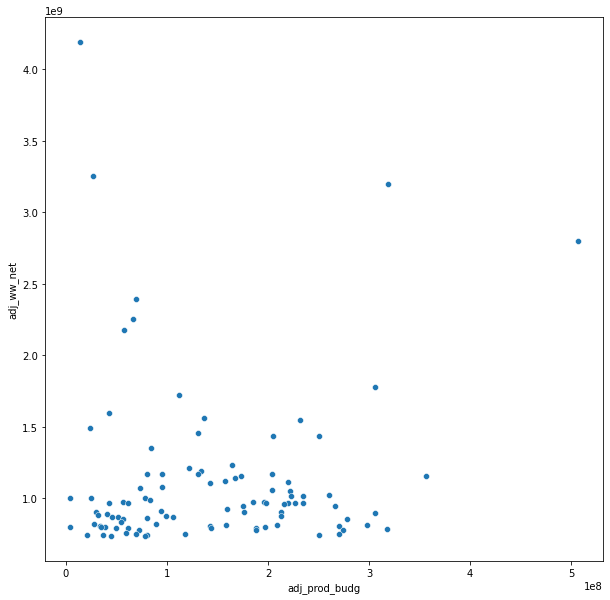

In [95]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(data=top100_net_films, x="adj_prod_budg", y="adj_ww_net")
plt.show()

In [96]:
title_roi = df[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_roi', 'year']]
unique_titles = title_roi.groupby('title').first().reset_index()
top20_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top20_roi_films

,title,adj_prod_budg,adj_ww_gross,adj_ww_roi,year
1909,Mad Max,6.205267e+05,3.094877e+08,497.750000,1980
2303,Paranormal Activity,5.362509e+05,2.314018e+08,430.517853,2009
3294,The Gallows,1.078644e+05,4.493251e+07,415.564740,2015
3090,The Blair Witch Project,9.207335e+05,3.810302e+08,412.833333,1999
2936,Super Size Me,8.797091e+04,3.009121e+07,341.058585,2004
352,Bambi,1.345728e+07,4.203440e+09,311.354312,1942
996,El Mariachi,1.238477e+04,3.612686e+06,290.704000,1993
2557,Rocky,4.493093e+06,1.010946e+09,224.000000,1976
3129,The Brothers McMullen,8.387697e+04,1.749087e+07,207.530120,1995
3797,The Texas Chainsaw Massacre,7.260037e+05,1.377978e+08,188.803136,1974


In [97]:
split_list = []
for genre in df.genres:
    split_list += genre.split(',')

raw_genres = list(set(split_list))
raw_genres

['Kids & Family',
 'Cult Movies',
 ' Cult Movies',
 ' Art House & International',
 ' Special Interest',
 'Comedy',
 'Art House & International',
 ' Comedy',
 'Western',
 'Science Fiction & Fantasy',
 ' Animation',
 ' Sports & Fitness',
 ' Gay & Lesbian',
 ' Mystery & Suspense',
 ' Romance',
 'Mystery & Suspense',
 ' Horror',
 ' Science Fiction & Fantasy',
 'Musical & Performing Arts',
 ' Television',
 ' Faith & Spirituality',
 ' Musical & Performing Arts',
 ' Western',
 ' Classics',
 'Drama',
 'Animation',
 'Horror',
 ' Drama',
 ' Kids & Family',
 ' Anime & Manga',
 'Romance',
 'Documentary',
 'Classics',
 'Action & Adventure',
 ' Documentary']

In [98]:
split_list = []
for genre in df.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))
genres

['cult movies',
 'western',
 'classics',
 'science fiction & fantasy',
 'horror',
 'documentary',
 'faith & spirituality',
 'action & adventure',
 'sports & fitness',
 'gay & lesbian',
 'mystery & suspense',
 'kids & family',
 'animation',
 'anime & manga',
 'television',
 'drama',
 'musical & performing arts',
 'romance',
 'comedy',
 'art house & international',
 'special interest']

In [110]:
len(genres)

21

In [118]:
action = df[(df['genres'] == 'Action & Adventure')]
unique_titles = action.groupby('title').first().reset_index()
top100_action = unique_titles.sort_values(by='adj_ww_net', ascending=False)
top100_action

,title,rating,genres,top,fresh,rotten,date,production_budget,domestic_gross,worldwide_gross,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
60,The Avengers,PG-13,Action & Adventure,21,4,78,2012-05-04,225000000.0,623279547.0,1.517936e+09,...,6.940329e+08,1.690249e+09,9.962157e+08,2.505415e+08,4.434914e+08,1.439707e+09,7.456742e+08,1.770131,5.746382,2.976250
48,Raiders of the Lost Ark,PG,Action & Adventure,19,76,4,1981-06-12,20000000.0,225686079.0,3.674521e+08,...,6.347440e+08,1.033462e+09,3.987180e+08,5.625017e+07,5.784938e+08,9.772118e+08,3.424679e+08,10.284304,17.372604,6.088300
27,Indiana Jones and the Last Crusade,PG-13,Action & Adventure,15,63,9,1989-05-24,48000000.0,197171806.0,4.741718e+08,...,4.065190e+08,9.776237e+08,5.711048e+08,9.896400e+07,3.075550e+08,8.786597e+08,4.721408e+08,3.107746,8.878579,4.770833
28,Indiana Jones and the Temple of Doom,PG,Action & Adventure,10,58,11,1984-05-23,28000000.0,179880271.0,3.330803e+08,...,4.426145e+08,8.195794e+08,3.769649e+08,6.889698e+07,3.737176e+08,7.506825e+08,3.080679e+08,5.424295,10.895724,4.471429
26,Indiana Jones and the Kingdom of the Crystal S...,PG-13,Action & Adventure,53,215,59,2008-05-22,185000000.0,317101119.0,7.866354e+08,...,3.765350e+08,9.340736e+08,5.575386e+08,2.196743e+08,1.568607e+08,7.143993e+08,3.378642e+08,0.714060,3.252083,1.538023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,Ironclad,R,Action & Adventure,22,23,32,2011-07-08,25000000.0,0.0,5.297411e+06,...,0.000000e+00,6.020833e+06,6.020833e+06,2.841404e+07,-2.841404e+07,-2.239320e+07,-2.239320e+07,-1.000000,-0.788104,-0.788104
68,The Gunman,R,Action & Adventure,47,29,149,2015-03-20,40000000.0,10664749.0,1.859423e+07,...,1.150347e+07,2.005655e+07,8.553085e+06,4.314577e+07,-3.164230e+07,-2.308921e+07,-3.459268e+07,-0.733381,-0.535144,-0.801763
22,Harley Davidson and the Marlboro Man,R,Action & Adventure,2,4,15,1991-08-23,23000000.0,7018525.0,7.018525e+06,...,1.317427e+07,1.317427e+07,0.000000e+00,4.317262e+07,-2.999836e+07,-2.999836e+07,-4.317262e+07,-0.694847,-0.694847,-1.000000
42,Mortdecai,R,Action & Adventure,25,13,97,2015-01-23,60000000.0,7696134.0,3.039613e+07,...,8.301390e+06,3.278661e+07,2.448522e+07,6.471865e+07,-5.641726e+07,-3.193204e+07,-4.023343e+07,-0.871731,-0.493398,-0.621667


In [130]:
scifi.groupby('title').first().reset_index()

,title,rating,genres,top,fresh,rotten,date,production_budget,domestic_gross,worldwide_gross,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,10 Cloverfield Lane,PG-13,"Drama, Mystery & Suspense, Science Fiction & F...",52,278,31,2016-03-11,5000000.0,72082999.0,108286422.0,...,7.678327e+07,1.153474e+08,3.856412e+07,5.326032e+06,7.145724e+07,1.100214e+08,3.323809e+07,13.416600,20.657284,6.240685
1,17 Again,PG-13,"Comedy, Drama, Science Fiction & Fantasy",43,83,65,2009-04-17,40000000.0,64167069.0,139474906.0,...,7.646588e+07,1.662079e+08,8.974198e+07,4.766674e+07,2.879914e+07,1.185411e+08,4.207524e+07,0.604177,2.486873,0.882696
2,2001: A Space Odyssey,G,"Classics, Science Fiction & Fantasy",28,103,9,1968-04-02,10500000.0,59936321.0,71928046.0,...,4.403201e+08,5.284169e+08,8.809679e+07,7.713789e+07,3.631822e+08,4.512790e+08,1.095891e+07,4.708221,5.850290,0.142069
3,2012,PG-13,"Action & Adventure, Drama, Mystery & Suspense,...",51,96,148,2009-11-13,200000000.0,166112167.0,757677748.0,...,1.979506e+08,9.029008e+08,7.049501e+08,2.383337e+08,-4.038307e+07,6.645670e+08,4.666164e+08,-0.169439,2.788389,1.957828
4,47 Ronin,PG-13,"Action & Adventure, Drama, Science Fiction & F...",20,14,74,2013-12-25,175000000.0,38362475.0,151716815.0,...,4.210062e+07,1.665005e+08,1.243999e+08,1.920525e+08,-1.499519e+08,-2.555197e+07,-6.765259e+07,-0.780786,-0.133047,-0.352261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,X-Men: Days of Future Past,PG-13,"Action & Adventure, Science Fiction & Fantasy",60,295,32,2014-05-23,200000000.0,233921534.0,747862775.0,...,2.526176e+08,8.076353e+08,5.550177e+08,2.159849e+08,3.663269e+07,5.916504e+08,3.390328e+08,0.169608,2.739314,1.569706
680,X-Men: First Class,PG-13,"Action & Adventure, Drama, Science Fiction & F...",56,253,42,2011-06-03,160000000.0,146408305.0,355408305.0,...,1.664020e+08,4.039434e+08,2.375413e+08,1.818498e+08,-1.544780e+07,2.220935e+08,5.569151e+07,-0.084948,1.221302,0.306250
681,X-Men: The Last Stand,PG-13,"Action & Adventure, Science Fiction & Fantasy",50,136,102,2006-05-26,210000000.0,234362462.0,459260946.0,...,2.972044e+08,5.824071e+08,2.852027e+08,2.663094e+08,3.089501e+07,3.160977e+08,1.889336e+07,0.116012,1.186957,0.070945
682,Yesterday Was a Lie,PG,"Drama, Mystery & Suspense, Science Fiction & F...",1,5,1,2008-01-17,200000.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,2.374858e+05,-2.374858e+05,-2.374858e+05,-2.374858e+05,-1.000000,-1.000000,-1.000000


In [133]:
scifi = df[(df['genres'].str.contains('science fiction & fantasy', case=False))]
unique_titles = scifi.drop_duplicates(subset = ['title'])
top100_scifi = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top100_scifi

,title,rating,genres,top,fresh,rotten,date,production_budget,domestic_gross,worldwide_gross,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
1054,Bambi,G,"Animation, Classics, Kids & Family, Science Fi...",6,46,5,1942-08-13,858000.0,102797000.0,2.680000e+08,...,1.612317e+09,4.203440e+09,2.591123e+09,1.345728e+07,1.598860e+09,4.189983e+09,2.577666e+09,118.810023,311.354312,191.544289
357,Snow White and the Seven Dwarfs,G,"Animation, Classics, Kids & Family, Science Fi...",8,52,1,1937-12-21,1488000.0,184925486.0,1.849255e+08,...,3.283159e+09,3.283159e+09,0.000000e+00,2.641789e+07,3.256741e+09,3.256741e+09,-2.641789e+07,123.277880,123.277880,-1.000000
1019,Avatar,PG-13,"Action & Adventure, Comedy, Mystery & Suspense...",63,259,58,2009-12-18,425000000.0,760507625.0,2.776345e+09,...,9.062730e+08,3.308483e+09,2.402210e+09,5.064591e+08,3.998139e+08,2.802024e+09,1.895751e+09,0.789430,5.532577,3.743147
1021,Avengers: Infinity War,PG-13,"Action & Adventure, Science Fiction & Fantasy",57,400,72,2018-04-27,300000000.0,678815482.0,2.048134e+09,...,6.911155e+08,2.085246e+09,1.394130e+09,3.054359e+08,3.856795e+08,1.779810e+09,1.088695e+09,1.262718,5.827114,3.564396
2529,Jurassic Park,PG-13,"Action & Adventure, Mystery & Suspense, Scienc...",34,117,11,1993-06-11,63000000.0,395708305.0,1.038813e+09,...,7.001079e+08,1.837922e+09,1.137814e+09,1.114629e+08,5.886450e+08,1.726459e+09,1.026351e+09,5.281084,15.489089,9.208004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3900,Man of Steel,PG-13,"Action & Adventure, Science Fiction & Fantasy",59,186,148,2013-06-14,225000000.0,291045518.0,6.679995e+08,...,3.194058e+08,7.330913e+08,4.136855e+08,2.469246e+08,7.248118e+07,4.861667e+08,1.667608e+08,0.293536,1.968887,0.675351
706,Puss in Boots,PG,"Action & Adventure, Animation, Comedy, Kids & ...",31,132,22,2011-10-28,130000000.0,149260504.0,5.549875e+08,...,1.696437e+08,6.307774e+08,4.611336e+08,1.477530e+08,2.189075e+07,4.830244e+08,3.133807e+08,0.148158,3.269134,2.120977
3684,Signs,PG-13,"Mystery & Suspense, Science Fiction & Fantasy",44,174,62,2002-08-02,70702619.0,227969295.0,4.082693e+08,...,3.239686e+08,5.801940e+08,2.562254e+08,1.004759e+08,2.234926e+08,4.797181e+08,1.557495e+08,2.224340,4.774458,1.550118
1414,Cinderella,G,"Animation, Classics, Kids & Family, Science Fi...",7,34,1,2015-03-13,95000000.0,201151353.0,5.345514e+08,...,2.169707e+08,5.765907e+08,3.596200e+08,1.024712e+08,1.144995e+08,4.741195e+08,2.571488e+08,1.117383,4.626856,2.509474


In [123]:
list(df[df['title'] == 'Mad Max'].genres)

['Action & Adventure, Cult Movies, Science Fiction & Fantasy']